In [3]:
import numpy as np
import pandas as pd
import anndata as ad
import scipy.sparse as sp
import scanpy as sc
from scipy.io import mmread
import requests
import os
from tqdm import trange
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
def download_file(doi,ext):
    url = 'https://api.datacite.org/dois/'+doi+'/media'
    r = requests.get(url).json()
    netcdf_url = r['data'][0]['attributes']['url']
    r = requests.get(netcdf_url,stream=True)
    #Set file name
    fname = doi.split('/')[-1]+ext
    #Download file with progress bar
    if r.status_code == 403:
        print("File Unavailable")
    if 'content-length' not in r.headers:
        print("Did not get file")
    else:
        with open(fname, 'wb') as f:
            total_length = int(r.headers.get('content-length'))
            pbar = trange(int(total_length/1024), unit="B")
            for chunk in r.iter_content(chunk_size=1024):
                if chunk:
                    pbar.update()
                    f.write(chunk)
        return fname

### Import GB data

##### Integrated data

In [6]:
data_path = "/data/cephfs-1/work/projects/aging-gbm/EmbeddingProject/"

# Data was filtered & log1p-normalized and 2000 most highly variable genes were selected, not scaled
expr_matrix = pd.read_csv(f"{data_path}integrated_sobj_expression_matrix.csv", index_col=0).T  # Transpose for Scanpy
metadata = pd.read_csv(f"{data_path}integrated_sobj_metadata.csv", index_col=0)

In [5]:
adata = ad.AnnData(X=sp.csr_matrix(expr_matrix.values), obs=metadata, var=pd.DataFrame(index=expr_matrix.columns))

In [7]:
# Metadata named as for the other samples
adata.obs['Cluster'] = metadata.Unique_Cluster_ID.values
adata.obs['n_count_rna'] = metadata.nCount_RNA.values

In [ ]:
# Clusters are named based on the most-frequent cell-type in the cluster
cluster_to_name = (
    adata.obs[['Cluster', 'Cluster_Annotations']]
    .dropna(subset=["Cluster"])  
    .astype({"Cluster": int})  
    .groupby("Cluster")["Cluster_Annotations"]
    .agg(lambda x: x.mode()[0]) 
    .to_dict()
)

In [31]:
adata_final = ad.AnnData(
    X=adata.X.copy(),
    obs=pd.DataFrame({  
        "clusterlabels": adata.obs["Cluster"].values,  # Numeric cluster labels
        "clusternames": clusternames,  # Mapped cluster names
        "n_count_rna": adata.obs["n_count_rna"].values,  # RNA counts 
        "is_malignant": adata.obs["is_malignant"].values,
        "orig.ident": adata.obs["orig.ident"].values
    }, index=adata.obs.index),
    var=pd.DataFrame(index=adata.var.index), 
    uns=dict(dataset="O_RTK1_m_2a+b")
)

In [32]:
adata_final.layers['X_scaled'] = sc.pp.scale(adata_final.X, copy=True)

In [36]:
adata_final.write_h5ad('../data/preprocessed/O_RTK1_m_2a+b_adata.h5ad')

In [35]:
adata_final.obs.head()

,clusterlabels,clusternames,n_count_rna,is_malignant,orig.ident
O_RTK1_m_2a_AAACAAGCAACCTTGTAGTGAGTG-1,2,GB.AC,1279,Malignant,O_RTK1_m_2a
O_RTK1_m_2a_AAACAAGCACAGCAACAGTGAGTG-1,1,GB.NPC1,963,Malignant,O_RTK1_m_2a
O_RTK1_m_2a_AAACAAGCACCTCGACAGTGAGTG-1,29,GB.MES2,2155,Non-Malignant,O_RTK1_m_2a
O_RTK1_m_2a_AAACAAGCATCCCTCTAGTGAGTG-1,9,Neurons_excit,865,Non-Malignant,O_RTK1_m_2a
O_RTK1_m_2a_AAACAAGCATGCAATGAGTGAGTG-1,33,BDM,2416,Non-Malignant,O_RTK1_m_2a


In [24]:
adata_test = adata

In [25]:
sc.pp.pca(adata_test)
sc.pp.neighbors(adata_test, n_pcs=20)
sc.tl.umap(adata_test)

/data/cephfs-1/home/users/lzaschk_m/work/miniforge3/envs/elephant_analysis_env/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


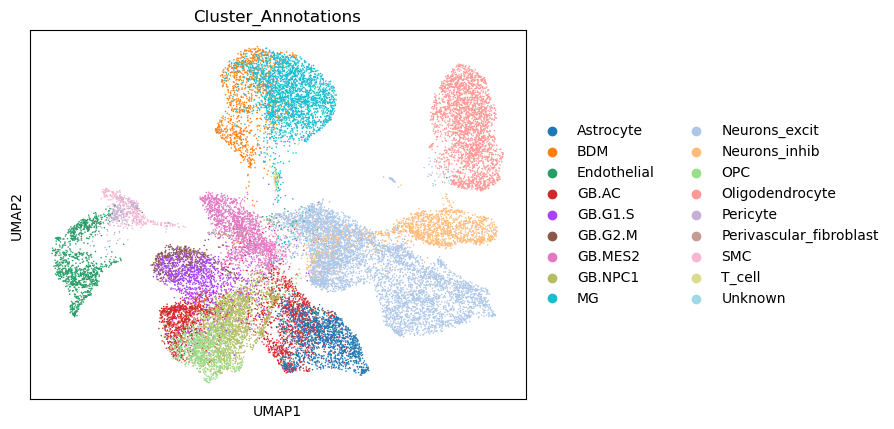

In [29]:
sc.pl.umap(adata_test, color=['Cluster_Annotations']) 

##### Unintegrated data

###### Sample 1: O_RTKA1_m_2a

In [39]:
data_path = "/data/cephfs-1/work/projects/aging-gbm/EmbeddingProject/"

expr_matrix = pd.read_csv(f"{data_path}O_RTK1_m_2a_expression_matrix.csv", index_col=0).T  # Transpose for Scanpy
metadata = pd.read_csv(f"{data_path}O_RTK1_m_2a_metadata.csv", index_col=0)

In [40]:
adata = ad.AnnData(X=sp.csr_matrix(expr_matrix.values), obs=metadata, var=pd.DataFrame(index=expr_matrix.columns))

In [41]:
# Meta-data as below
adata.obs['Cluster'] = metadata.seurat_clusters.values
adata.obs['n_count_rna'] = metadata.nCount_RNA.values

In [45]:
adata.obs["Cluster_Annotations"].unique()

array(['GB.AC', 'GB.NPC1', 'GB.MES2', 'Neurons_excit', 'BDM', 'GB.G1.S',
       'Oligodendrocyte', 'MG', 'GB.G2.M', 'SMC', 'Endothelial',
       'Astrocyte', 'T_cell', 'OPC', 'Neurons_inhib', 'Unknown'],
      dtype=object)

In [46]:
sc.pp.log1p(adata)
sc.pp.filter_cells(adata, min_counts=0)
sc.pp.filter_genes(adata, min_counts=0)
sc.pp.highly_variable_genes(adata,n_top_genes=2000)

In [48]:
cluster_to_name = (
    adata.obs[['Cluster', 'Cluster_Annotations']]
    .dropna(subset=["Cluster"])  # Remove NaNs
    .astype({"Cluster": int})  # Ensure 'Cluster' is an integer
    .groupby("Cluster")["Cluster_Annotations"]
    .agg(lambda x: x.mode()[0])  # Get the most frequent cell type
    .to_dict()
)

In [49]:
clusternames = [
    cluster_to_name.get(int(x), "Missing") if not pd.isna(x) else "Missing"
    for x in adata.obs["Cluster"].values
]

In [50]:
adata_final = ad.AnnData(
    X=adata.X.copy(),
    obs=pd.DataFrame({  
        "clusterlabels": adata.obs["Cluster"].values,  # Numeric cluster labels
        "clusternames": clusternames,  # Mapped cluster names
        "n_count_rna": adata.obs["n_count_rna"].values  # RNA counts 
    }, index=adata.obs.index),
    var=pd.DataFrame({  
        "highly_variable": adata.var["highly_variable"].values  # Keep HVG info
    }, index=adata.var.index),
    uns=dict(dataset="O_RTK1_m_2a")  # Add dataset metadata
)

In [51]:
# subset to highly-variable genes
adata_final = adata_final[:, adata_final.var['highly_variable']].copy()

In [52]:
# scaling
adata_final.layers['X_scaled'] = sc.pp.scale(adata_final.X, copy=True)

In [53]:
# save 
adata_final.write_h5ad('../data/preprocessed/O_RTK1_m_2a_adata.h5ad')

In [54]:
adata_test = adata_final

In [55]:
sc.pp.pca(adata_test)
sc.pp.neighbors(adata_test, n_pcs=20)
sc.tl.umap(adata_test)

/data/cephfs-1/home/users/lzaschk_m/work/miniforge3/envs/elephant_analysis_env/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


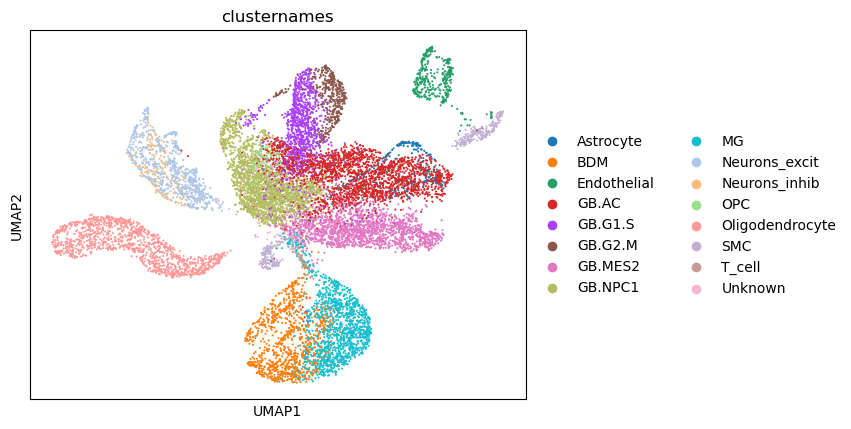

In [56]:
sc.pl.umap(adata_test, color=['clusternames']) 

###### Sample 2: O_RTKA1_m_2b

In [57]:
data_path = "/data/cephfs-1/work/projects/aging-gbm/EmbeddingProject/"

expr_matrix = pd.read_csv(f"{data_path}O_RTK1_m_2b_expression_matrix.csv", index_col=0).T  # Transpose for Scanpy
metadata = pd.read_csv(f"{data_path}O_RTK1_m_2b_metadata.csv", index_col=0)

In [58]:
adata = ad.AnnData(X=sp.csr_matrix(expr_matrix.values), obs=metadata, var=pd.DataFrame(index=expr_matrix.columns))

In [59]:
# Meta-data as below
adata.obs['Cluster'] = metadata.seurat_clusters.values
adata.obs['n_count_rna'] = metadata.nCount_RNA.values

In [60]:
sc.pp.log1p(adata)
sc.pp.filter_cells(adata, min_counts=0)
sc.pp.filter_genes(adata, min_counts=0)
sc.pp.highly_variable_genes(adata,n_top_genes=2000)

In [61]:
cluster_to_name = (
    adata.obs[['Cluster', 'Cluster_Annotations']]
    .dropna(subset=["Cluster"])  # Remove NaNs
    .astype({"Cluster": int})  # Ensure 'Cluster' is an integer
    .groupby("Cluster")["Cluster_Annotations"]
    .agg(lambda x: x.mode()[0])  # Get the most frequent cell type
    .to_dict()
)

In [62]:
clusternames = [
    cluster_to_name.get(int(x), "Missing") if not pd.isna(x) else "Missing"
    for x in adata.obs["Cluster"].values
]

In [70]:
adata_final = ad.AnnData(
    X=adata.X.copy(),
    obs=pd.DataFrame({  
        "clusterlabels": adata.obs["Cluster"].values,  # Numeric cluster labels
        "clusternames": clusternames,  # Mapped cluster names
        "n_count_rna": adata.obs["n_count_rna"].values  # RNA counts (if relevant)
    }, index=adata.obs.index),
    var=pd.DataFrame({  
        "highly_variable": adata.var["highly_variable"].values  # Keep HVG info
    }, index=adata.var.index),
    uns=dict(dataset="O_RTK1_m_2b")  # Add dataset metadata
)

In [71]:
# subset to highly-variable genes
adata_final = adata_final[:, adata_final.var['highly_variable']].copy()

In [72]:
# scaling
adata_final.layers['X_scaled'] = sc.pp.scale(adata_final.X, copy=True)

In [73]:
# save 
adata_final.write_h5ad('../data/preprocessed/O_RTK1_m_2b_adata.h5ad')

In [68]:
adata_test = adata_final
sc.pp.pca(adata_test)
sc.pp.neighbors(adata_test, n_pcs=20)
sc.tl.umap(adata_test)

/data/cephfs-1/home/users/lzaschk_m/work/miniforge3/envs/elephant_analysis_env/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


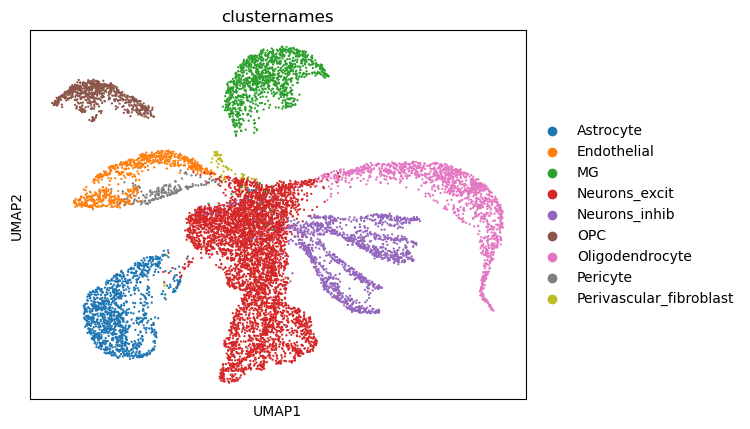

In [69]:
sc.pl.umap(adata_test, color=['clusternames']) 

### Prepare Ex Utero data

In [3]:
#Download
!wget -O ../data/raw/GSE149372_scRNA.MetaData.85.csv.gz https://ftp.ncbi.nlm.nih.gov/geo/series/GSE149nnn/GSE149372/suppl/GSE149372_scRNA.MetaData.85.csv.gz
!wget -O ../data/raw/GSE149372_scRNA.normalized.assay85.csv.gz https://ftp.ncbi.nlm.nih.gov/geo/series/GSE149nnn/GSE149372/suppl/GSE149372_scRNA.normalized.assay85.csv.gz
!gunzip -f -k ../data/raw/*.gz

--2025-02-18 19:47:30--  https://ftp.ncbi.nlm.nih.gov/geo/series/GSE149nnn/GSE149372/suppl/GSE149372_scRNA.MetaData.85.csv.gz
Resolving ftp.ncbi.nlm.nih.gov (ftp.ncbi.nlm.nih.gov)... 130.14.250.31, 130.14.250.7, 130.14.250.11, ...
Connecting to ftp.ncbi.nlm.nih.gov (ftp.ncbi.nlm.nih.gov)|130.14.250.31|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 224984 (220K) [application/x-gzip]
Saving to: ‘../data/raw/GSE149372_scRNA.MetaData.85.csv.gz’

../data/raw/GSE1493 100%[===================>] 219.71K   119KB/s    in 1.8s    

2025-02-18 19:47:34 (119 KB/s) - ‘../data/raw/GSE149372_scRNA.MetaData.85.csv.gz’ saved [224984/224984]

--2025-02-18 19:47:34--  https://ftp.ncbi.nlm.nih.gov/geo/series/GSE149nnn/GSE149372/suppl/GSE149372_scRNA.normalized.assay85.csv.gz
Resolving ftp.ncbi.nlm.nih.gov (ftp.ncbi.nlm.nih.gov)... 130.14.250.12, 130.14.250.10, 130.14.250.13, ...
Connecting to ftp.ncbi.nlm.nih.gov (ftp.ncbi.nlm.nih.gov)|130.14.250.12|:443... connected.
HTTP reques

In [4]:
# Load full data
counts_e85 = pd.read_csv('../data/raw/GSE149372_scRNA.normalized.assay85.csv',index_col=0)
cellMeta_e85 = pd.read_csv('../data/raw/GSE149372_scRNA.MetaData.85.csv')
counts_e85.shape

(19588, 10290)

In [5]:
#process metadata for all E8.5 data
count_mat_e85 = counts_e85.values.T
adata_e85 = anndata.AnnData(X = count_mat_e85)
adata_e85.obs_names = list(counts_e85.columns)
adata_e85.var_names = list(counts_e85.index)
adata_e85.obs['Utero'] = cellMeta_e85.Utero.values
adata_e85.obs['Cluster'] = cellMeta_e85.seurat_clusters.values
adata_e85.obs['n_count_rna'] = cellMeta_e85.nCount_RNA.values

#subset to only ex-utero data
adata_exut = adata_e85[adata_e85.obs['Utero']=='ExUt']

#celltype infos and colors as Chari&Pachter
celltype_dict = {'0' : 'Blood', '11': 'Blood' ,
                 '1' : 'Somitic Mesoderm',
                 '2' : 'Foregut Mid-hindgut',
                 '3' : 'Cardiac',
                 '4' : 'Mid-hindbrain',
                 '5' : 'Endothelial',
                 '6' : 'Presomitic/Mixed Mesoderm',
                 '7' : 'Amnion', '15' : 'Amnion', '17' : 'Amnion',
                 '8' : 'Extra-Embryonic Endoderm',
                 '9' : 'Pharyngeal Mesoderm',
                 '10': 'Extra-Embryonic Ectoderm',
                 '12': 'Placodes',
                 '13': 'Neural Tube', '16' : 'Neural Tube',
                 '14': 'Extra-Embryonic Mesoderm',
                 '18': 'Endothelial'}

color_dict = {'Blood':'#70D4CE','Presomitic/Mixed Mesoderm':'#81A483','Foregut Mid-hindgut':'#4D50E3',
        'Cardiac':'#E0B7CF','Mid-hindbrain':'#FC514A','Endothelial':'#EDE7D1',
        'Amnion':'#B4CA72',
        'Extra-Embryonic Endoderm':'#C7A2F3','Pharyngeal Mesoderm':'#CCD0BC','Extra-Embryonic Ectoderm':'#73F0FD',
        'Placodes':'#AE995B','Neural Tube':'#87BD7E','Somitic Mesoderm':'#D34FEA',
        'Extra-Embryonic Mesoderm':'#0F5813'}

colors_exut = [color_dict[celltype_dict[str(cl)]] for cl in adata_exut.obs['Cluster'].values]
colors_new = np.array(list(colors_exut.copy()),dtype='<U15')

#add extra colors for clusters that get the same colors in the original Chari&Pachter palette
colors_new[adata_exut.obs['Cluster'].values==11]='tab:red'
colors_new[adata_exut.obs['Cluster'].values==15]='tab:orange'
colors_new[adata_exut.obs['Cluster'].values==16]='tab:blue'
colors_new[adata_exut.obs['Cluster'].values==17]='tab:green'

adata_exut.obs['colors'] = colors_new

adata_exut.shape

/tmp/ipykernel_2923090/3245848769.py:46: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata_exut.obs['colors'] = colors_new


(6205, 19588)

In [6]:
#preprocess as Chari & Pachter 
sc.pp.filter_cells(adata_exut, min_counts=0)
sc.pp.filter_genes(adata_exut, min_counts=0)
sc.pp.highly_variable_genes(adata_exut,n_top_genes=2000)
adata_exut.shape

(6205, 19588)

In [7]:
#re-create anndata with needed fields only
adata_exut_allgenes = anndata.AnnData(X=adata_exut.X.copy(),
                               obs=dict(clusterlabels=adata_exut.obs['Cluster'].values,
                                        clusternames=[celltype_dict[str(x)] for x in adata_exut.obs['Cluster'].values],
                                        colors=colors_new,
                                        n_count_rna = adata_exut.obs['n_count_rna'].values),
                               var=dict(highly_variable=adata_exut.var['highly_variable'].values),
                               uns=dict(dataset='exut-allgenes'))

### undo log1p
adata_exut_allgenes.layers['normalized_counts'] = np.expm1(adata_exut_allgenes.X.copy())
### show that counts were normalized to sum to 10,000 per cell
print(adata_exut_allgenes.layers['normalized_counts'].sum(axis=1))
### un-do log1p and normalization with scaling by 10.000 using the seq depths from the metadata
adata_exut_allgenes.layers['raw'] = (adata_exut_allgenes.obs['n_count_rna'].values*(np.expm1(adata_exut_allgenes.X.copy())/10000).T).T

[10000. 10000. 10000. ... 10000. 10000. 10000.]


In [8]:
#apply hvg selection
adata_exut_hvgs = adata_exut_allgenes[:,adata_exut_allgenes.var['highly_variable']]
adata_exut_hvgs.uns['dataset']='exut'

/tmp/ipykernel_2923090/3848050230.py:3: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata_exut_hvgs.uns['dataset']='exut'


In [9]:
#Chari&Pachter scaling
adata_exut_hvgs.layers['X_scaled'] = sc.pp.scale(adata_exut_hvgs.X.copy())
adata_exut_hvgs.shape

(6205, 2000)

In [10]:
#save
adata_exut_hvgs.write_h5ad('../data/preprocessed/exut_adata.h5ad')

In [11]:
adata_exut_hvgs

AnnData object with n_obs × n_vars = 6205 × 2000
    obs: 'clusterlabels', 'clusternames', 'colors', 'n_count_rna'
    var: 'highly_variable'
    uns: 'dataset'
    layers: 'normalized_counts', 'raw', 'X_scaled'

In [12]:
adata_exut_hvgs.obs

,clusterlabels,clusternames,colors,n_count_rna
0,1,Somitic Mesoderm,#D34FEA,12663
1,0,Blood,#70D4CE,14587
2,13,Neural Tube,#87BD7E,9380
3,1,Somitic Mesoderm,#D34FEA,9267
4,9,Pharyngeal Mesoderm,#CCD0BC,2002
...,...,...,...,...
6200,0,Blood,#70D4CE,6036
6201,1,Somitic Mesoderm,#D34FEA,12097
6202,0,Blood,#70D4CE,14804
6203,6,Presomitic/Mixed Mesoderm,#81A483,12619


### Prepare simulated ex-utero data

In [13]:
#simulate data
clusters,clustersizes = np.unique(adata_exut_allgenes.obs['clusterlabels'].values,return_counts=True)

np.random.seed(seed=42)
theta=10
X_sim=[]
clusterlabels_sim = []
X_real=[]
for i,(cluster,size) in enumerate(zip(clusters,clustersizes)):
    
    cluster_idx = adata_exut_allgenes.obs['clusterlabels'].values == cluster
    clustercounts_raw = adata_exut_allgenes.layers['raw'][cluster_idx,:]
    X_real += [clustercounts_raw]
    
    #compute marginals per cluster
    ns = np.sum(clustercounts_raw,axis=1)
    ps = np.sum(clustercounts_raw,axis=0)
    ps = ps / np.sum(ps)
    mus = np.outer(ns,ps)
    
    #simulate
    if theta == np.Inf: #Poisson case
        X_sim += [np.random.poisson(mus)]
    else:
        nb_p = theta / (theta + mus)           
        X_sim += [np.random.negative_binomial(np.ones_like(nb_p)*theta, nb_p)]
     
    clusterlabels_sim += [cluster]*size

clusterlabels_sim=np.array(clusterlabels_sim)
#colors for re-ordered simulated data
colors_sim = [color_dict[celltype_dict[str(cl)]] for cl in clusterlabels_sim]
colors_new_sim = np.array(list(colors_sim.copy()),dtype='<U15')
colors_new_sim[clusterlabels_sim==11]='tab:red'
colors_new_sim[clusterlabels_sim==15]='tab:orange'
colors_new_sim[clusterlabels_sim==16]='tab:blue'
colors_new_sim[clusterlabels_sim==17]='tab:green'

adata_sim = anndata.AnnData(X=np.concatenate(X_sim),
                            obs=dict(clusterlabels=clusterlabels_sim,
                                     colors=colors_new_sim),
                            uns=dict(dataset=f'exut-sim-theta-{theta}-real-seqdepths'),
                            layers=dict(X_real=np.concatenate(X_real)))

In [14]:
#preprocess like before
adata_sim.layers['raw'] = adata_sim.X.copy()
sc.pp.normalize_total(adata_sim,target_sum=10000)
sc.pp.log1p(adata_sim)
sc.pp.filter_cells(adata_sim, min_counts=0)
sc.pp.filter_genes(adata_sim, min_counts=0)
adata_sim

AnnData object with n_obs × n_vars = 6205 × 19588
    obs: 'clusterlabels', 'colors', 'n_counts'
    var: 'n_counts'
    uns: 'dataset', 'log1p'
    layers: 'X_real', 'raw'

In [15]:
#select HVGs
sc.pp.highly_variable_genes(adata_sim,n_top_genes=2000)
adata_sim = adata_sim[:,adata_sim.var['highly_variable']]
adata_sim

View of AnnData object with n_obs × n_vars = 6205 × 2000
    obs: 'clusterlabels', 'colors', 'n_counts'
    var: 'n_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'dataset', 'log1p', 'hvg'
    layers: 'X_real', 'raw'

In [16]:
adata_sim.layers['X_scaled'] = sc.pp.scale(adata_sim.X.copy())
adata_sim.write_h5ad(f'../data/preprocessed/{adata_sim.uns["dataset"]}_adata.h5ad')

/tmp/ipykernel_2923090/45398618.py:1: ImplicitModificationWarning: Setting element `.layers['X_scaled']` of view, initializing view as actual.
  adata_sim.layers['X_scaled'] = sc.pp.scale(adata_sim.X.copy())


In [17]:
adata_sim

AnnData object with n_obs × n_vars = 6205 × 2000
    obs: 'clusterlabels', 'colors', 'n_counts'
    var: 'n_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'dataset', 'log1p', 'hvg'
    layers: 'X_real', 'raw', 'X_scaled'

/tmp/ipykernel_2923090/1111178664.py:67: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


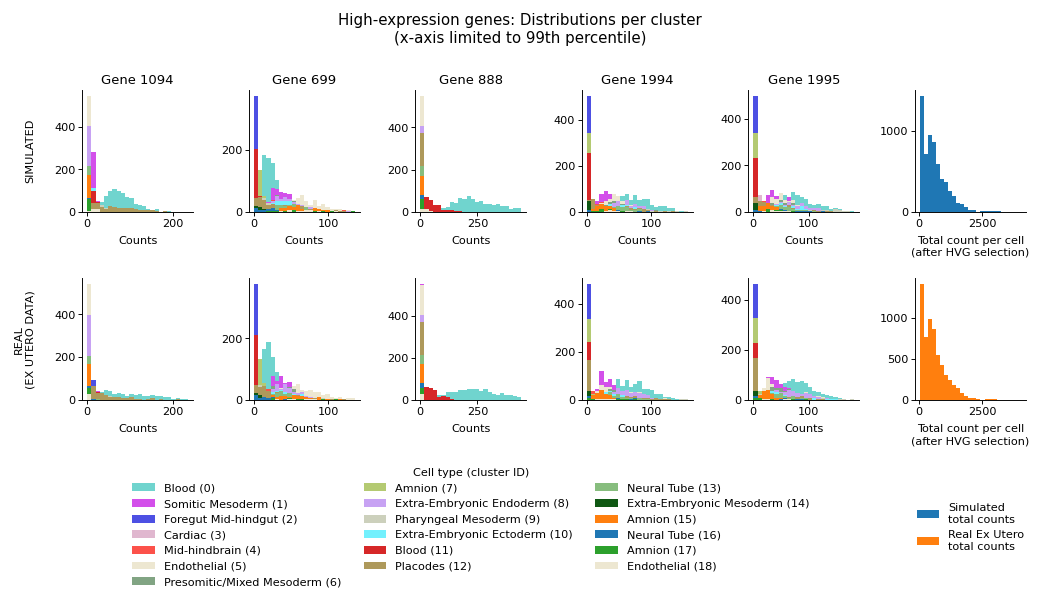

In [18]:
largest_gene_idx = np.argsort(np.mean(adata_sim.layers['raw'],axis=0))[-5:]

with plt.style.context('../mpl_style.txt'):
    
    ## PREPARE
    nrows_grid = 3
    ncols_grid = 6
    fig = plt.figure(figsize=(7.8,4.5))
    axes_sim = [plt.subplot2grid(shape=(nrows_grid,ncols_grid), loc=(0, col), colspan=1,rowspan=1) for col in range(ncols_grid)]
    axes_real = [plt.subplot2grid(shape=(nrows_grid,ncols_grid), loc=(1, col), colspan=1,rowspan=1) for col in range(ncols_grid)]
    ax_legend = plt.subplot2grid(shape=(nrows_grid,ncols_grid), loc=(2, 0), colspan=5,rowspan=1)    
    ax_legend_small = plt.subplot2grid(shape=(nrows_grid,ncols_grid), loc=(2, 5), colspan=1,rowspan=1)    
    
    plt.suptitle("High-expression genes: Distributions per cluster\n(x-axis limited to 99th percentile)")
    
    ## CLUSTER DISTRIBUTIONS
    for clm,(gene_idx) in enumerate(largest_gene_idx):
        
        p99count_sim = np.percentile(adata_sim.layers['raw'][:,gene_idx],99)
        p99count_real = np.percentile(adata_sim.layers['X_real'][:,gene_idx],99)
        p99count = np.max([p99count_sim,p99count_real])
        bins=np.linspace(0,p99count+1,num=25)

        for cluster in range(19):

            cluster_idx = adata_sim.obs['clusterlabels'].values == cluster
            color = np.unique(adata_sim[cluster_idx].obs['colors'])[0]

            X_cl_sim = adata_sim.layers['raw'][cluster_idx,:]
            X_cl_real = adata_sim.layers['X_real'][cluster_idx,:]

            plt.sca(axes_sim[clm])
            # plt.yscale('log')
            plt.title(f'Gene {gene_idx}')
            counts_sim=X_cl_sim[:,gene_idx] 
            plt.hist(counts_sim,bins=bins,color=color)
            plt.xlabel('Counts')
            if clm==0:
                  plt.ylabel('SIMULATED\n')


            plt.sca(axes_real[clm])
            # plt.yscale('log')
            counts_real=X_cl_real[:,gene_idx]    
            plt.hist(counts_real,bins=bins,color=color,label=f'{celltype_dict[str(cluster)]} ({cluster})')
            plt.xlabel('Counts')
            if clm==0:
                plt.ylabel('REAL\n(EX UTERO DATA)\n')
                
                h, l = axes_real[clm].get_legend_handles_labels()
                ax_legend.legend(h,l,frameon=False,title='Cell type (cluster ID)',ncol=3,loc='center')
                ax_legend.axis("off")
    
    ## TOTAL COUNTS
    plt.sca(axes_sim[5])
    _,bins,_ = plt.hist(np.sum(adata_sim.layers['raw'],axis=1),bins=25,color='tab:blue',label='Simulated\ntotal counts')
    plt.xlabel('Total count per cell\n(after HVG selection)')
    h1, l1 = axes_sim[5].get_legend_handles_labels()

    plt.sca(axes_real[5])
    plt.hist(np.sum(adata_sim.layers['X_real'],axis=1),bins=bins,color='tab:orange',label='Real Ex Utero\ntotal counts')
    plt.xlabel('Total count per cell\n(after HVG selection)')
    h2, l2 = axes_real[5].get_legend_handles_labels()
    ax_legend_small.legend(h1+h2,l1+l2,frameon=False,loc='center')
    ax_legend_small.axis("off")

plt.tight_layout()
sns.despine()
fig.savefig(f'../results/figures/supplementary/{adata_sim.uns["dataset"]}_real_vs_sim_cluster_distributions.pdf', dpi=300, format=None, bbox_inches = 'tight', pad_inches = 0)
fig.savefig(f'../results/figures/supplementary/{adata_sim.uns["dataset"]}_real_vs_sim_cluster_distributions.png', dpi=300, format=None, bbox_inches = 'tight', pad_inches = 0)    
plt.show()

### Prepare MERFISH data

In [19]:
#download and unpack
#metadata.csv
download_file('10.22002/D1.2063','.gz')
#counts.h5ad
download_file('10.22002/D1.2064','.gz')

os.system("gunzip D1.2063.gz")
os.system("gunzip D1.2064.gz")
os.system("mv D1.2063 ../data/raw/merfish_metadata.csv")
os.system("mv D1.2064 ../data/raw/merfish_counts.h5ad")

9785B [00:12, 767.08B/s]                            
59361B [00:13, 4301.72B/s]                            


0

In [20]:
#load full MERFISH data
counts_merfish = anndata.read_h5ad('../data/raw/merfish_counts.h5ad')
cellMeta_merfish = pd.read_csv('../data/raw/merfish_metadata.csv')
counts_merfish.shape

(280327, 254)

In [21]:
#process clusternames and colors
counts_merfish.obs['slice'] = pd.Categorical(cellMeta_merfish.slice_id)
counts_merfish.obs['clusternames'] = pd.Categorical(cellMeta_merfish.subclass)
_,clusterlabels_merfish = np.unique(counts_merfish.obs['clusternames'],return_inverse=True)
counts_merfish.obs['clusterlabels'] = clusterlabels_merfish

cdict = {'Microglia':'#A778BC',
         'L6_IT':'#EA95C1',
         'Astrocytes':'#B6657E','Oligodendrocytes':'#B49599',
         'L23_IT':'#628EA2','OPC':'#72B9A5','L45_IT':'#71B7A2','Endothelial':'#7794C3','Pvalb':'#FD8085',
         'L6_IT_Car3':'#FAD1FC','L56_NP':'#93B09B','PVM':'#ECBDD2','L5_IT':'#ABA8DF',
         'L5_PT':'#D36486','Sst':'#8FE0B1','L6_CT':'#9589C4','Vip':'#CD83AC','VLMC':'#BBDBF2',
         'SMC':'#7A849E','other':'#A382BC','L6b':'#64D7F0','Pericytes':'#95BA98',
         'Lamp5':'#A3E169','Sncg':'#92B1DB','Sst_Chodl':'#81FAC9'}
counts_merfish.obs['colors'] = [cdict[i] for i in counts_merfish.obs['clusternames']]


#subset MERFISH data to same slide as Chari & Pachter
slice_choice = np.unique(cellMeta_merfish.slice_id)[7]

subset_merfish = counts_merfish[counts_merfish.obs['slice'].isin([slice_choice])]
subset_merfish.shape

(6963, 254)

In [22]:
#preprocess as Chari&Pachter
sc.pp.log1p(subset_merfish)
subset_merfish.uns['dataset'] = 'merfish'
#Chari&Pachter scaling
subset_merfish.layers['X_scaled'] = sc.pp.scale(subset_merfish.X.copy())

/data/cephfs-1/work/groups/ludwig/users/lzaschk_m/miniforge3/envs/elephant_analysis_env/lib/python3.11/site-packages/scanpy/preprocessing/_simple.py:372: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


In [23]:
#save
subset_merfish.write_h5ad('../data/preprocessed/merfish_adata.h5ad')

In [24]:
subset_merfish

AnnData object with n_obs × n_vars = 6963 × 254
    obs: 'slice', 'clusternames', 'clusterlabels', 'colors'
    uns: 'log1p', 'dataset'
    layers: 'X_scaled'

In [25]:
subset_merfish.obs

,slice,clusternames,clusterlabels,colors
index,,,,
100028810813183819239792138762506953059,mouse1_slice162,Microglia,12,#A778BC
100042292675978612289781789372249900646,mouse1_slice162,L6_IT,8,#EA95C1
100093902545314506370058151058375627035,mouse1_slice162,Astrocytes,0,#B6657E
100140206101682663983686904841717501025,mouse1_slice162,Oligodendrocytes,14,#B49599
100176313983591085952263714025726530686,mouse1_slice162,L23_IT,2,#628EA2
...,...,...,...,...
99658397536625795119891455351124847928,mouse1_slice162,L6_IT_Car3,9,#FAD1FC
99716035693339658241621650353650240200,mouse1_slice162,Astrocytes,0,#B6657E
99757070583384140112761609672322877368,mouse1_slice162,L23_IT,2,#628EA2


### Prepare SmartSeq

In [26]:
# Download and unpack
#metadata.csv
download_file('10.22002/D1.2067','.gz')
#smartseq.mtx (log counts)
download_file('10.22002/D1.2071','.gz')

os.system("gunzip D1.2067.gz")
os.system("gunzip D1.2071.gz")

os.system("mv D1.2067 ../data/raw/smartseq_metadata.csv")
os.system("mv D1.2071 ../data/raw/smartseq.mtx")

65B [00:00, 121.97B/s]                        
26701B [00:04, 6176.48B/s]                            


0

In [27]:
#load data
counts_smartseq = mmread('../data/raw/smartseq.mtx')
meta_smartseq = pd.read_csv('../data/raw/smartseq_metadata.csv')
counts_smartseq.shape

(3850, 1999)

In [28]:
#add metadata
adata_smartseq = anndata.AnnData(X=counts_smartseq)
adata_smartseq.obs['clusternames'] = [s for s in meta_smartseq.smartseq_cluster]
_,smartseq_clusterlabels = np.unique(meta_smartseq.smartseq_cluster,return_inverse=True)
adata_smartseq.obs['clusterlabels'] = smartseq_clusterlabels
adata_smartseq.obs['colors'] = [c for c in meta_smartseq.smartseq_cluster_color]
adata_smartseq.uns['dataset']='smartseq'

In [29]:
#Chari&Pachter scaling
adata_smartseq.layers['X_scaled'] = sc.pp.scale(adata_smartseq.X.copy())

In [30]:
adata_smartseq.write_h5ad('../data/preprocessed/smartseq_adata.h5ad')

In [31]:
adata_smartseq

AnnData object with n_obs × n_vars = 3850 × 1999
    obs: 'clusternames', 'clusterlabels', 'colors'
    uns: 'dataset'
    layers: 'X_scaled'

In [32]:
adata_smartseq.obs

,clusternames,clusterlabels,colors
0,Nr5a1_9|11 Rorb,18,#6C39A6
1,Nr5a1_9|11 Rorb,18,#6C39A6
2,Nr5a1_9|11 Rorb,18,#6C39A6
3,Nr5a1_4|7 Glipr1,16,#763BFF
4,Nr5a1_4|7 Glipr1,16,#763BFF
...,...,...,...
3845,Nr5a1_Foxp2_1 Prdm13,19,#D92AAB
3846,Nr5a1_Foxp2_1 Prdm13,19,#D92AAB
3847,Nr5a1_Foxp2_1 Prdm13,19,#D92AAB
3848,Nr5a1_Foxp2_1 Prdm13,19,#D92AAB


### Prepare MNIST data

In [33]:
import sklearn.datasets
#download
x_mnist,y_mnist = sklearn.datasets.fetch_openml('mnist_784',version=1,return_X_y=True)

#adjust datatypes
y_mnist = y_mnist.values.astype(int)
x_mnist = x_mnist.values

#metadata
colors_tab10 = np.array(['tab:blue','tab:orange','tab:green','tab:red','tab:purple','tab:brown','tab:pink','tab:gray','tab:olive','tab:cyan'])
colors_mnist = colors_tab10[y_mnist]

#make adata and save
adata_mnist = anndata.AnnData(X=x_mnist,
                               obs=dict(clusterlabels=y_mnist,
                                        clusternames=[str(y) for y in y_mnist],
                                        colors=colors_mnist),
                               uns=dict(dataset='mnist'))
adata_mnist.layers['X_scaled'] = sc.pp.scale(adata_mnist.X.copy())
adata_mnist.write_h5ad('../data/preprocessed/mnist_adata.h5ad')

/data/cephfs-1/work/groups/ludwig/users/lzaschk_m/miniforge3/envs/elephant_analysis_env/lib/python3.11/site-packages/sklearn/datasets/_openml.py:1002: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


In [34]:
adata_mnist

AnnData object with n_obs × n_vars = 70000 × 784
    obs: 'clusterlabels', 'clusternames', 'colors'
    uns: 'dataset'
    layers: 'X_scaled'

In [35]:
adata_mnist.obs

,clusterlabels,clusternames,colors
0,5,5,tab:brown
1,0,0,tab:blue
2,4,4,tab:purple
3,1,1,tab:orange
4,9,9,tab:cyan
...,...,...,...
69995,2,2,tab:green
69996,3,3,tab:red
69997,4,4,tab:purple
69998,5,5,tab:brown


### Copyright notice

This notebook uses code adapted from https://github.com/pachterlab/CP_2023, which is subject to the following licence:

```
BSD 2-Clause License

Copyright (c) 2021, Pachter Lab
All rights reserved.

Redistribution and use in source and binary forms, with or without
modification, are permitted provided that the following conditions are met:

1. Redistributions of source code must retain the above copyright notice, this
   list of conditions and the following disclaimer.

2. Redistributions in binary form must reproduce the above copyright notice,
   this list of conditions and the following disclaimer in the documentation
   and/or other materials provided with the distribution.

THIS SOFTWARE IS PROVIDED BY THE COPYRIGHT HOLDERS AND CONTRIBUTORS "AS IS"
AND ANY EXPRESS OR IMPLIED WARRANTIES, INCLUDING, BUT NOT LIMITED TO, THE
IMPLIED WARRANTIES OF MERCHANTABILITY AND FITNESS FOR A PARTICULAR PURPOSE ARE
DISCLAIMED. IN NO EVENT SHALL THE COPYRIGHT HOLDER OR CONTRIBUTORS BE LIABLE
FOR ANY DIRECT, INDIRECT, INCIDENTAL, SPECIAL, EXEMPLARY, OR CONSEQUENTIAL
DAMAGES (INCLUDING, BUT NOT LIMITED TO, PROCUREMENT OF SUBSTITUTE GOODS OR
SERVICES; LOSS OF USE, DATA, OR PROFITS; OR BUSINESS INTERRUPTION) HOWEVER
CAUSED AND ON ANY THEORY OF LIABILITY, WHETHER IN CONTRACT, STRICT LIABILITY,
OR TORT (INCLUDING NEGLIGENCE OR OTHERWISE) ARISING IN ANY WAY OUT OF THE USE
OF THIS SOFTWARE, EVEN IF ADVISED OF THE POSSIBILITY OF SUCH DAMAGE.
```

### Package versions

In [36]:
np.__version__

'1.24.3'

In [37]:
pd.__version__

'2.0.3'

In [38]:
anndata.__version__

'0.10.3'

In [39]:
sc.__version__

'1.9.6'

In [40]:
import scipy; scipy.__version__

'1.11.1'

In [41]:
requests.__version__

'2.32.3'

In [42]:
import tqdm; tqdm.__version__

'4.67.1'